# BertCause

## Training

In [1]:
import random
import torch
import numpy as np
import os

def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_random_seed(1337)

In [2]:
import csv

def read_records(file_name):
    records = []
    with open(file_name, "r") as r:
        reader = csv.reader(r, delimiter="\t")
        header = next(reader)
        for row in reader:
            r = dict(zip(header, row))
            result = r["result"]
            mapping = {
                "bad": 0,
                "rel": 0,
                "same": 0,
                "left_right_cause": 1,
                "left_right_cancel": 1,
                "right_left_cause": 2,
                "right_left_cancel": 2
            }
            if result not in mapping:
                continue
            r["label"] = mapping[result]
            records.append(r)
    return records

ru_records = read_records("ru_news_cause_v2.tsv")


In [3]:
from collections import Counter

ru_labels_counter = Counter([r["label"] for r in ru_records])
print(ru_labels_counter)

labels_count = len(ru_labels_counter)

Counter({0: 3605, 2: 925, 1: 875})


In [4]:
from collections import defaultdict

def split_with_source(records, val_border=0.8, test_border=0.9):
    records_by_source = defaultdict(list)
    for r in records:
        source = r["id"].split("_")[0]
        records_by_source[source].append(r)

    train_records, val_records, test_records = [], [], []
    for _, source_records in records_by_source.items():
        source_records.sort(key=lambda x: min(x["left_timestamp"], x["right_timestamp"]))
        val_border = int(0.8 * len(source_records))
        test_border = int(0.9 * len(source_records))
        train_records.extend(source_records[:val_border])
        val_records.extend(source_records[val_border:test_border])
        test_records.extend(source_records[test_border:])
    return train_records, val_records, test_records

ru_train_records, ru_val_records, ru_test_records = split_with_source(ru_records)
print("RU:")
print(len(ru_train_records))
print(len(ru_val_records))
print(len(ru_test_records))
print()

RU:
4323
540
542



In [5]:
from transformers import pipeline
import random
import torch
import numpy as np
import os
import random
from transformers import AutoModelForSequenceClassification, AutoTokenizer

def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:2"
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def pipe_predict(data, batch_size=64):
    raw_preds = pipe(data, batch_size=batch_size)
    preds = np.array([int(max(labels, key=lambda x: x["score"])["label"][-1]) for labels in raw_preds])
    pp = np.array([[l["score"] for l in labels] for labels in raw_preds])
    return preds, pp
    
set_random_seed(1337)

MODEL_NAME = "xlm-roberta-large"
TOKENIZER_NAME = MODEL_NAME

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
MODEL_NAME = "./bertcause-task0/checkpoint-192"
MAX_TOKENS = 80

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
model = model.to("cuda")


model.eval()
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, framework="pt", device=0, return_all_scores=True)



/media/altsoph/Volume/_py37/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '
2021-08-09 10:59:06.356534: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [6]:
import numpy as np

ru_y_true = np.array([r["label"] for r in ru_test_records], dtype=np.int32)
print(ru_y_true)


[2 1 0 1 0 0 0 0 2 1 2 1 0 1 1 1 2 1 0 0 0 0 0 1 0 0 2 1 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 2 1 0 1 1 0 2 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 1 2 0 0 0 1 0 1 0 0 0 2 0 2 0 0 0 1 0 0 0 0 2 0 0 0 2 0 1 1 0 0 0 0 0 0
 2 0 1 1 0 1 1 2 0 0 1 0 0 0 0 1 1 0 0 0 2 0 1 0 2 0 0 0 2 0 2 2 1 0 1 0 0
 0 0 2 1 0 0 0 2 0 0 0 0 1 2 1 2 1 2 0 0 0 1 0 1 1 0 1 0 2 0 2 2 1 0 2 2 0
 0 0 0 1 1 2 0 0 0 2 0 1 1 0 1 2 2 0 1 0 2 0 1 2 1 1 1 2 0 2 2 0 0 0 0 0 0
 0 0 2 1 0 1 0 0 0 0 2 0 0 0 1 0 2 0 0 0 1 0 1 1 0 0 0 0 0 2 1 0 0 2 1 0 0
 1 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 2 2 2 1 1 2 0 0 0 0 0 1 0 0 1 1
 0 1 0 1 0 0 1 1 0 0 0 0 0 0 2 0 0 2 0 0 0 0 1 0 1 2 1 0 0 1 0 2 0 0 1 2 1
 1 0 0 0 1 1 0 2 2 1 2 1 1 1 0 1 1 0 0 0 1 2 1 2 0 1 2 0 2 2 0 2 0 0 2 0 2
 0 0 0 1 2 2 0 0 0 0 2 2 1 0 0 1 1 2 0 1 0 0 0 0 0 1 0 0 0 2 0 2 0 1 2 2 1
 2 0 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 2 1 0 2 0 1 2 2 0 0 2 0 0
 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 2 1 1 2 0 0 1 2 0 2 2 0 1 0 0 0 1 1 0 2
 1 1 1 1 2 1 1 2 1 1 1 1 

In [7]:
infer_pairs = [(r["left_title"], r["right_title"]) for r in ru_test_records]
ru_y_pred = pipe_predict(infer_pairs)[0]
ru_y_pred

array([2, 0, 0, 1, 0, 0, 0, 0, 2, 1, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0,
       0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 1, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2,
       2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0,
       0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0,
       2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2,
       0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0,
       0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 1, 0,

In [8]:
from sklearn.metrics import classification_report, balanced_accuracy_score
print(classification_report(ru_y_true, ru_y_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.82       291
           1       0.67      0.05      0.10       148
           2       0.35      0.71      0.47       103

    accuracy                           0.61       542
   macro avg       0.60      0.54      0.46       542
weighted avg       0.67      0.61      0.56       542



In [9]:
xs = []
ys = []
for cc in ('0.7','0.8','0.9','1.0',):
    mask = [r["mv_part"]==cc for r in ru_test_records]
    print(f'confidence\t{cc}\tbacc\t{balanced_accuracy_score(ru_y_true[mask], ru_y_pred[mask]):0.3}\tnum\t{np.sum(mask)}' )
    xs.append(float(cc))
    ys.append( balanced_accuracy_score(ru_y_true[mask], ru_y_pred[mask]) )


confidence	0.7	bacc	0.513	num	107
confidence	0.8	bacc	0.483	num	117
confidence	0.9	bacc	0.544	num	134
confidence	1.0	bacc	0.592	num	184


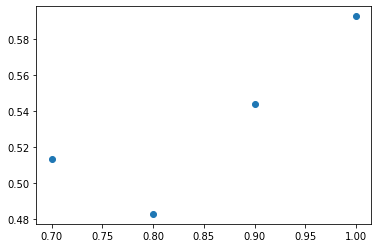

In [30]:
import matplotlib.pyplot as plt

plt.scatter(xs,ys)
plt.show()